In this notebook, we create a training dataset. A dataset is a set of input Hamiltonians $H_i$, and output observed values $y(H_i)$.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import time
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from calc_expected_value import calculate_expected_value
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
import networkx as nx
import cupy as cp

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
n_qubits = 40
n_samples = 55
beta = 1.0

### Check graph (i.e., Heisenberg Hamiltonian)

The Hamiltonian used in this code is the one-dimentional Heisenberg model with open boundary conditions:

\begin{aligned}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{aligned}

The  interaction strengths $\{J_i\}$ are randomly sampled from a uniform distribution over the interval $[-1, 1]$.

This Hamiltonian is represented as a graph using the `networkx` library.

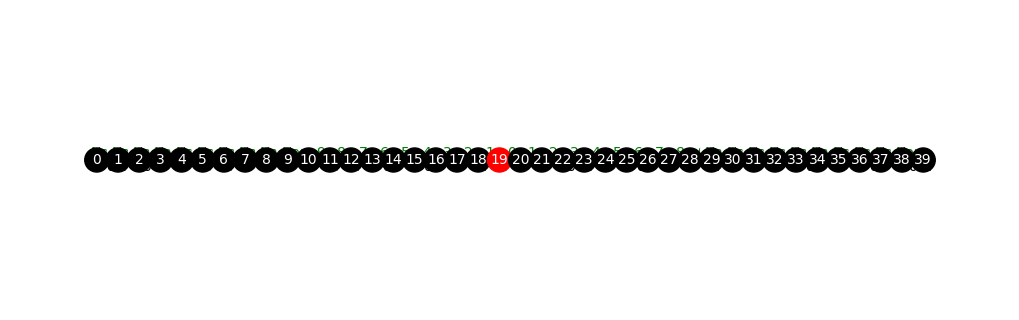

In [7]:
rng = np.random.default_rng(42)

# Generate Js using a uniform distribution from -1 to 1. Then normalize so that sum(|Js|) = 1
Js = rng.uniform(-1, 1, size=n_qubits - 1)
Js /= np.sum(np.abs(Js))

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# Create edge labels
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# Plot the graph
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# Plot the edge labels
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# Plot the cnot order labels
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In the figure above:
- The circles represent spins, which are mapped to qubits when running the quantum circuit.
- The red circle indicates the qubit on which the Hadamard gate is applied at the beginning of the GHZ state preparation.
- The green numbers on the edges represent the order in which CNOT gates are applied during the GHZ part. To efficiently spread entanglement, CNOT gates are applied sequentially starting from the qubit with the Hadamard gate. The target GHZ state is $\ket{00111100}$, meaning that CNOT operations are applied only to the central half of the qubits. 'None' indicates qubits that are not affected by any CNOT gate and thus remain in the $\ket{0}$ state.
- The black numbers on the edges represent the interaction strengths $J_{ij}$. "Generating a random Hamiltonian" refers to randomly assigning these $J_{ij}$ values.

## Create dataset

We create a dataset for supervised learning, consisting of paired inputs and outputs.

input: Hamiltonian $H$

output: $y(H)=\operatorname{Tr}[f(H)\rho]$

In this code,
- $f(H)=e^{-\beta H}$
- $\rho=\ket{\psi}\bra{\psi} (pure state), \ket{\psi}=\ket{0011\cdots1100}$ (the central half is 1, while the rest are 0).

Therefore,

output: $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$.

In the following, we first prepare the state $\ket{\psi}=\ket{0011\cdots1100}$.

Next, we compute $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$ using imaginary-time TEBD to create the dataset. For systems with up to 12 qubits, we verify the accuracy of the imaginary-time TEBD results by comparing them with exact values.

In [8]:
data = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")

    # Generate Js using a uniform distribution from -1 to 1. Then normalize so that sum(|Js|) = 1
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    data.append(
        {
            "sample": i,
            "Js": Js,
            "expected_value": expected_value_tebd,
            "expected_value_diag": expected_value_diag,
            "diff": diff,
        }
    )

df = pd.DataFrame(data)
print(f"diff mean: {df['diff'].mean():.3e}")
print(
    "Note: The expected value is calculated by TEBD. \nFor small number of qubits, to check the accuracy, the expected value is also calculated by diagonalizing the Hamiltonian."
)
display(df)
df["expected_value"].describe()

# Save as json (save each line with orient="records")
df.to_json(
    f"results/get_dataset/{n_qubits}Q/dataset.json",
    orient="records",
    indent=4,
)

Sample 0/55
Elapsed time for TEBD: 10.39[s]

Sample 1/55
Elapsed time for TEBD: 10.32[s]

Sample 2/55
Elapsed time for TEBD: 10.30[s]

Sample 3/55
Elapsed time for TEBD: 10.25[s]

Sample 4/55
Elapsed time for TEBD: 10.31[s]

Sample 5/55
Elapsed time for TEBD: 10.32[s]

Sample 6/55
Elapsed time for TEBD: 10.29[s]

Sample 7/55
Elapsed time for TEBD: 10.27[s]

Sample 8/55
Elapsed time for TEBD: 10.29[s]

Sample 9/55
Elapsed time for TEBD: 10.28[s]

Sample 10/55
Elapsed time for TEBD: 10.27[s]

Sample 11/55
Elapsed time for TEBD: 10.29[s]

Sample 12/55
Elapsed time for TEBD: 10.27[s]

Sample 13/55
Elapsed time for TEBD: 10.25[s]

Sample 14/55
Elapsed time for TEBD: 10.24[s]

Sample 15/55
Elapsed time for TEBD: 10.31[s]

Sample 16/55
Elapsed time for TEBD: 10.30[s]

Sample 17/55
Elapsed time for TEBD: 10.32[s]

Sample 18/55
Elapsed time for TEBD: 10.26[s]

Sample 19/55
Elapsed time for TEBD: 10.28[s]

Sample 20/55
Elapsed time for TEBD: 10.25[s]

Sample 21/55
Elapsed time for TEBD: 10.30[s]

,sample,Js,expected_value,expected_value_diag,diff
0,0,"[0.027569343690844305, -0.006150918405629181, ...",0.913388,None,None
1,1,"[0.019811133354944256, -0.00733209131939022, 0...",1.057062,None,None
2,2,"[0.005929263532505271, 0.02951505824513449, 0....",1.009956,None,None
3,3,"[0.025590596058158596, -0.007918327633576857, ...",1.115899,None,None
4,4,"[-0.019974216938600853, 0.014555914282102768, ...",0.906205,None,None
5,5,"[-0.03138710882876255, 0.009725694630467192, 0...",0.956448,None,None
6,6,"[0.039712621543895286, 0.02791298307241974, -0...",1.192622,None,None
7,7,"[0.009764741923626015, 0.019360948348913425, -...",0.961146,None,None
8,8,"[-0.027742315276333723, -0.013743889304910857,...",0.915409,None,None
9,9,"[-0.03571570399210524, 0.00705718115261178, 0....",0.926034,None,None


### (Appx.) Comparison between TEBD and exact calculation as the number of qubits increases

In [18]:
n_qubits_list = [4, 8, 12, 20, 40, 60, 80, 100]
expected_values_tebd = []
expected_values_diag = []
diffs = []
rng = np.random.default_rng(42)
n_qubits_diag_upper_bound = 12

for n_qubits in n_qubits_list:
    print(f"processing for {n_qubits} qubits...")

    # Generate Js using a uniform distribution from -1 to 1. Then normalize so that sum(|Js|) = 1
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    expected_values_tebd.append(expected_value_tebd)
    expected_values_diag.append(expected_value_diag)
    diffs.append(diff)

df = pd.DataFrame(
    {
        "n_qubits": n_qubits_list,
        "expected_value_tebd": expected_values_tebd,
        "expected_value_diag": expected_values_diag,
        "diff": diffs,
    }
)
display(df)

processing for 4 qubits...


Elapsed time for TEBD: 0.93[s]
Elapsed time for diagonalization: 0.00[s]

processing for 8 qubits...
Elapsed time for TEBD: 2.11[s]
Elapsed time for diagonalization: 0.00[s]

processing for 12 qubits...
Elapsed time for TEBD: 3.19[s]
Elapsed time for diagonalization: 0.43[s]

processing for 20 qubits...
Elapsed time for TEBD: 5.16[s]

processing for 40 qubits...
Elapsed time for TEBD: 10.01[s]

processing for 60 qubits...
Elapsed time for TEBD: 14.91[s]

processing for 80 qubits...
Elapsed time for TEBD: 19.81[s]

processing for 100 qubits...
Elapsed time for TEBD: 24.81[s]



,n_qubits,expected_value_tebd,expected_value_diag,diff
0,4,5.547457,5.547451,5.591330e-06
1,8,0.457030,0.457030,4.929879e-09
2,12,1.111247,1.111247,3.868749e-07
3,20,0.853209,NaN,NaN
4,40,1.034675,NaN,NaN
5,60,1.109520,NaN,NaN
6,80,1.061310,NaN,NaN
7,100,1.127011,NaN,NaN
